<img src="https://pmarote.net/tcc/icmc_logo.png"  width="192px" align="right">
<p style="text-align: center; font-size: 200%; font-weight: bold; margin-top: 10px;"><b>UNIVERSIDADE DE SÃO PAULO</b></a></p>
<p style="text-align: center; font-size: 150%; font-weight: bold; margin-top: 10px;">Instituto de Ciências Matemáticas e de Computação</a></p><br>

---
### <div style="text-align: center"><font color="navy">Uso de técnicas de processamento de linguagem natural:<br><br>Aplicação em Decisões do Contencioso Administrativo Fiscal na Secretaria da Fazenda do Estado de São Paulo.</font></div>
### <div style="text-align: left"><font color= #333>Paulo Ricardo dos Santos Olim Marote<br><br>Trabalho de Conclusão de Curso - MBA em Ciência de Dados (CEMEAI)</font></div>
- **WebScraper de Andamentos de AIIMs e Decisões** em /var/www
- **Geração de db Sqlite e planilha Excel dos dados baixados** em /var
<p style="text-align: right; font-size: 100%; opacity: 0.8; margin-top: 0px;">USP - São Carlos - 2023</p>

## 🚴 Carregamento e Unzip de Bibliotecas Auxiliares e AIIMs já baixados anteriormente
- **Verificar a esquerda em 📁 se há arquivos carregados. Se não, utilizar este código logo ao iniciar**
  - Se desenv = True, carrega do google drive de Paulo Marote (necessário login)
  - Se desenv = False, carrega de um link aberto da internet

In [ ]:
from google.colab import drive
import shutil
import requests
import os
import zipfile

desenv = False

def download_and_local_save(url, caminho_local):
    # Fazer uma requisição GET para a URL
    response = requests.get(url)
    # Verificar se a requisição foi bem-sucedida
    if response.status_code == 200:
        with open(caminho_local, 'wb') as f:
            f.write(response.content)
        print(f"Arquivo baixado com sucesso de {url} e salvo como {caminho_local}.")
    else:
        print(f"Falha ao baixar o arquivo {url}. Código de status: {response.status_code}.")

def extrai(zip_file):
    # se o arquivo possuir "_", transforma para "/" e cria a pasta
    dir_extract_zip_file, extension = os.path.splitext(zip_file)
    dir_extract_zip_file = os.path.join('/content', dir_extract_zip_file)
    if '_' in dir_extract_zip_file:
        dir_extract_zip_file = os.path.join('/content',
                                            dir_extract_zip_file.replace("_", "/"))
    if os.path.exists(dir_extract_zip_file):
        shutil.rmtree(dir_extract_zip_file)
    os.makedirs(dir_extract_zip_file, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(dir_extract_zip_file))
    print(f"Extraído {zip_file} para {os.path.dirname(dir_extract_zip_file)} !")
    os.remove(zip_file)

if desenv:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    print(shutil.copy('/content/drive/MyDrive/Colab Notebooks/TCC/src/core.zip',
                      '/content/core.zip'),
          "copiado do Google Drive!")
    print(shutil.copy('/content/drive/MyDrive/Colab Notebooks/TCC/src/var_www.zip',
                      '/content/var_www.zip'),
          "copiado do Google Drive!")
else:
    download_and_local_save('https://www.pmarote.net/tcc/core.zip',
                            '/content/core.zip')
    download_and_local_save('https://www.pmarote.net/tcc/var_www.zip',
                            '/content/var_www.zip')

extrai('core.zip')
extrai('var_www.zip')

Arquivo baixado com sucesso de https://www.pmarote.net/tcc/core.zip e salvo como /content/core.zip.
Arquivo baixado com sucesso de https://www.pmarote.net/tcc/var_www.zip e salvo como /content/var_www.zip.
Extraído core.zip para /content !
Extraído var_www.zip para /content/var !


## 🔛 Importações e Inicialização
  - código inicial, carregando as bibliotecas necessárias, bem como as bibliotecas desenvolvidas para este TCC, que estão em /content/core
  - aqui também são definidas algumas funções 'helpers' para utilização nos códigos, como de formatação de números para português-Brasil

In [ ]:
import os
import ipywidgets as widgets
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output

import core  # apenas insere o diretório ./core em sys.path
from Config import Config
from WebScraper import WebScraper
from Db import Db
config = Config.getConfigs()
webscraper = WebScraper(config['CWEB_DIR'])
db = Db(config['VAR_DIR'])
print("config = ", config)

# duas funções para dar uma melhor formatação em português
def int_f(val):
    return "{:,}".format(val).replace(',','.')
def two_dec_f(val):
    return "{:,.2f}".format(val).replace(',','#').replace('.',',').replace('#','.')
# styler em português para pandas
def df_style(styler):
    styler.format(lambda v: f'{v:,.2f}'.replace(".", "#").
              replace(",", ".").replace("#", ",") if isinstance(v, float) else v)
    styler.applymap(lambda v: 'color:red;' if not isinstance(v, str) and v < 0 else None)
    styler.applymap(lambda v: 'opacity: 80%;'
                    if not isinstance(v, str) and abs(v) < 10000 else None)
    return styler


Banco de dados /content/var/tcc.db inexistente... Criando...
config =  {'SRC_DIR': '/content', 'VAR_DIR': '/content/var', 'CWEB_DIR': '/content/var/www'}


## 🏁 Web Scraper
  - Execute para habilitar os widgets
  - Automaticamente, o campo AIIM Inicial será preenchido com o próximo a ser baixado, ou seja, o número do último já carregado, adicionado de 1
  - O AIIM final é o AIIM Inicial mais 100, mas pode ser alterado a vontade
  - Clique no botão 'Baixa AIIMs" para iniciar o Web Scraper
  - Mas, como no início já foi carregado var.zip, que contém milhares de AIIMs anteriormente baixados, não há necessidade de baixar AIIMs adicionais. Assim, neste momento, este trecho é utilizado apenas para teste e verificação do funcionamento do Web Scraper

In [50]:
# Criando os widgets
aiim_ini = widgets.Text(value=str(webscraper.get_next_aiim_nr()), description='AIIM Inicial:')
aiim_fin = widgets.Text(value=str(webscraper.get_next_aiim_nr() + 100), description='AIIM Final:')
baixa_button = widgets.Button(description='Baixa AIIMs')

# Definindo as ações dos botões
def on_baixa_button_clicked(b):
    i_aiim_ini = int(aiim_ini.value)
    i_aiim_fin = int(aiim_fin.value)
    while(i_aiim_ini <= i_aiim_fin):
        res2 = webscraper.baixa_aiim(str(i_aiim_ini))
        if (res2 is not None):
            i_aiim_ini += 1
        else:
            break

baixa_button.on_click(on_baixa_button_clicked)
display(aiim_ini, aiim_fin, baixa_button)

Text(value='4128000', description='AIIM Inicial:')

Text(value='4128100', description='AIIM Final:')

Button(description='Baixa AIIMs', style=ButtonStyle())

Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4128000 com sucesso.
Html /content/var/www/4128000.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4128001 com sucesso.
Html /content/var/www/4128001.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4128002 com sucesso.
Html /content/var/www/4128002.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4128003 com sucesso.
Html /content/var/www/4128003.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4128004 com sucesso.
Html /content/var/www/4128004.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4128005 com sucesso.
Html /content/var/www/4128005.html salvo com sucesso.


## 👀 Visualização dos arquivos baixados do tipo .html e .pdf
  - Execute para habilitar os widgets
  - Automaticamente, o campo AIIM será preenchido com o valor do primeiro baixado
  - Clique no botão para gerar o link de visualização
  - Nesta etapa de desenvolvimento, está limitado aos AIIMs já baixados anteriormente, carregados no início deste notebook


In [ ]:
# Criando os widgets
aiim_view = widgets.Text(value=str(webscraper.get_first_aiim_nr()), description='Nro AIIM:')
link_button = widgets.Button(description='Gera link')

def view_display(nro_aiim: str):
    display(aiim_view, link_button)
    display(HTML(f'<a href="https://www.pmarote.net/tcc/cweb/www/{nro_aiim}.html" target="_blank">Visualizar AIIM {nro_aiim}</a>'))

def on_link_button_clicked(b):
    clear_output()
    view_display(aiim_view.value)

link_button.on_click(on_link_button_clicked)
view_display(aiim_view.value)

Text(value='4118000', description='Nro AIIM:')

Button(description='Gera link', style=ButtonStyle())

## ♻️ Preenchimento do banco de dados SQLite tcc.db
  - Este módulo deve sempre ser executado, embora demore um pouco
  - Basicamente, reinicializa a base de dados SQLite em /content/var/tcc.db e insere com os dados dos AIIMs já baixados que estão em /content/var/www utilizando Beautiful Soup

In [ ]:
def preenche_tcc_db():
    db.exec("DELETE FROM aiim;")
    db.exec("DELETE FROM aiim_mov;")
    db.exec("DELETE FROM aiim_decis;")
    print('Carregando os AIIMs e mostrando os números de 200 em 200, ',
          'para acompanhar o andamento')
    for i in range(webscraper.get_first_aiim_nr(), webscraper.get_next_aiim_nr()):
        html_file = os.path.join(config['CWEB_DIR'], f'{i}.html')
        db.html_to_db(html_file)
        print('.', end='') if i % 200 != 0 else print('\n', i, end='')
    db.conn.commit()
    print(f"\nFinalizado!")

preenche_tcc_db()


Carregando os AIIMs e mostrando os números de 200 em 200,  para acompanhar o andamento

 4118000.......................................................................................................................................................................................................
 4118200.......................................................................................................................................................................................................
 4118400.......................................................................................................................................................................................................
 4118600.......................................................................................................................................................................................................
 4118800........................................................................

## 🔍 Reindexação e Visualização das tabelas de tcc.db
  - No pandas, é importante definir uma coluna do DataFrame como índice, que é equivalente à definição de uma chave primária em termos de banco de dados relacional. Definir uma coluna como índice também é importante para fins de melhora de performance, bem como ao realizar operações entre diferentes DataFrames.
  - Conforme definição dos SQLs (abaixo), é de se observar que em todas as tabelas o campo numero (Número do AIIM) é inteiro e também faz parte da chave primária.
  - Assim, abaixo, após a criação de cada Dataframe, a definição do número do AIIM como índice, com inplace=True, para fins de modificação do DataFrame original.
  - Por fim, visualizações SQL básicas da base de dados SQLite em /content/var/tcc.db

In [51]:
display(HTML('<h3>Lista de Tabelas:</h3>'))
sql = """
SELECT * FROM sqlite_master WHERE type = 'table'
"""
df_tabelas = pd.read_sql_query(sql, db.conn)
display(df_tabelas.head().style.pipe(df_style))

qtd_aiims = db.sql_to_list('SELECT count(*) FROM aiim')[0][0]
nro_ini = str(db.sql_to_list('SELECT min(numero) FROM aiim')[0][0])
nro_fin = str(db.sql_to_list('SELECT max(numero) FROM aiim')[0][0])
display(HTML('<h3>Dataframe <i>df_aiim</i> - '
             + f' Total de AIIMs: {int_f(qtd_aiims)}'
             + f' ( de {int_f(int(nro_ini))} a {int_f(int(nro_fin))} )'
             + '</h3>'))
sql = """
SELECT * FROM aiim
"""
df_aiim = pd.read_sql_query(sql, db.conn)
df_aiim.set_index('numero', inplace=True)
display(df_aiim.head())
display(HTML('<h3>Dataframe <i>df_aiim_mov</i> - Itens de AIIMs já carregados: (head)</h3>'))
sql = """
SELECT * FROM aiim_mov
"""
df_aiim_mov = pd.read_sql_query(sql, db.conn)
df_aiim_mov.set_index('numero', inplace=True)
# Converter a coluna de data para datetime, depois somente data
df_aiim_mov['data'] = pd.to_datetime(df_aiim_mov['data'])
df_aiim_mov['data'] = df_aiim_mov['data'].dt.date
display(df_aiim_mov.head())

display(HTML('<h3>Dataframe <i>df_aiim_decis</i> - Decisões de AIIMs já carregados: (head)</h3>'))
sql = """
SELECT * FROM aiim_decis
"""
df_aiim_decis = pd.read_sql_query(sql, db.conn)
df_aiim_decis.set_index('numero', inplace=True)
# Converter a coluna de data para datetime, depois somente data
df_aiim_decis['data'] = pd.to_datetime(df_aiim_decis['data'])
df_aiim_decis['data'] = df_aiim_decis['data'].dt.date
display(df_aiim_decis.head())


,type,name,tbl_name,rootpage,sql
0,table,aiim,aiim,2,"CREATE TABLE aiim (numero INT PRIMARY KEY, nro_comp TEXT, drt TEXT, autuado TEXT, advogado TEXT, assunto TEXT, fase_proc TEXT)"
1,table,aiim_mov,aiim_mov,4,"CREATE TABLE aiim_mov (numero INT, item INT, data TEXT, descri TEXT, PRIMARY KEY (numero, item))"
2,table,aiim_decis,aiim_decis,6,"CREATE TABLE aiim_decis (numero INT, item INT, data TEXT, recurso TEXT, pdf_link TEXT, PRIMARY KEY (numero, item))"
3,table,df_dec,df_dec,2981,"CREATE TABLE ""df_dec"" ( ""index"" INTEGER, ""recurso"" TEXT, ""qtd"" INTEGER, ""%tot_aiims"" REAL, ""%decis_c_def"" REAL )"
4,table,df_dpi,df_dpi,2983,"CREATE TABLE ""df_dpi"" ( ""numero"" INTEGER, ""item"" INTEGER, ""data"" TEXT, ""julgado"" TEXT, ""it_posterior"" INTEGER, ""public"" TEXT, ""recurso"" TEXT, ""pdf_link"" TEXT )"


,nro_comp,drt,autuado,advogado,assunto,fase_proc
numero,,,,,,
4118000,4.118.000-8,SOROCABA,Marcos Roberto de Lena,NENHUM ADVOGADO/PROCURADOR CADASTRADO,ITCMD - ITCMD<br><br>,DEFESA
4118001,4.118.001-0,CAPITAL II,MPLF EMPREENDIMENTOS IMOBILIÁRIOS LTDA,MÁRCIA REGINA NIGRO CORRÊA e outros.,ITCMD - ITCMD<br><br>,OUTROS
4118003,4.118.003-3,CAPITAL II,ESPACO DIGITAL DISTRIBUIDOR DE ELETRO ELETRONI...,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA
4118006,4.118.006-9,CAPITAL III,DRAGTEC TUBOS DE AÇO HELICOIDAL LTDA,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA
4118007,4.118.007-0,CAPITAL II,ADITEX IND E COM DE ADITIVOS QUIMICOS LTDA,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA


,item,data,descri
numero,,,
4118000,0,2018-11-21,Notificação do AIIM
4118000,1,2018-12-20,Protocolo da Defesa (Marcos Roberto de Lena): ...
4118000,2,2019-01-11,Entrada do processo na Delegacia Tributária de...
4118000,3,2019-01-22,Distribuição da Defesa para Julgamento - DTJ-2...
4118000,4,2019-02-14,Julgamento: MANTIDO o Auto de Infração e Impos...


,item,data,recurso,pdf_link
numero,,,,
4118000,0,2019-02-15,DEFESA,4118000voto4810961.pdf
4118001,0,2019-04-01,DEFESA,4118001voto4816439.pdf
4118001,1,2019-05-20,OUTROS,4118001voto4818155.pdf
4118009,0,2019-02-25,DEFESA,4118009voto4812537.pdf
4118009,1,2019-03-20,DEFESA,4118009voto4815819.pdf


  - Distribuição das Decisões dos AIIMs:

In [ ]:
sql = """
SELECT recurso, count(recurso) AS qtd FROM
(SELECT *
FROM aiim_mov AS A
LEFT OUTER JOIN aiim_mov AS B ON B.numero = A.numero AND B.item = (A.item + 1)
LEFT OUTER JOIN aiim_decis AS C ON C.numero = A.numero AND C.data = B.data
WHERE A.descri LIKE '%CANCELADO%' OR A.descri LIKE '%MANTIDO%' OR A.descri LIKE '%REDUZIDO%')
GROUP BY recurso
HAVING qtd > 0
"""
df_dec = pd.read_sql_query(sql, db.conn)
df_dec['%tot_aiims'] = (df_dec['qtd'] / int(qtd_aiims)) * 100
total_qtd = df_dec['qtd'].sum()
df_dec['%decis_c_def'] = (df_dec['qtd'] / int(total_qtd)) * 100
msg = f'De {int_f(qtd_aiims)} carregados, há {int_f(total_qtd)}'
msg += f' AIIMs (' + two_dec_f(total_qtd / qtd_aiims * 100)
msg += f'%) com decisões, assim distribuídos:<br>(Tipos Diferentes: {df_dec.shape[0]})'
display(HTML(f'<h3>{msg}</h3>'))
display(df_dec.style.pipe(df_style))

,recurso,qtd,%tot_aiims,%decis_c_def
0,DEFESA,2342,"26,66","82,73"
1,RECURSO DE OFICIO,59,"0,67","2,08"
2,RECURSO VOLUNTARIO,392,"4,46","13,85"
3,RECURSO VOLUNTARIO / OFICIO,10,"0,11","0,35"
4,RETIFICAÇÃO,28,"0,32","0,99"


## 🧹 Seleção e Limpeza dos Dados (1)

Conforme se verifica acima:
  - Dos AIIMs carregados, cerca de 32% dos mesmos possuem decisões
  - Dos que possuem decisões, majoritariamente são as do tipo "DEFESA", ou seja, as decisões de primeira instância administrativa
  - Assim, para maior padronização, considerando a classe majoritária "DEFESA", selecionaremos apenas essa classe para este estudo do TCC.
  - Conforme SQL abaixo, para seleção dos dados, é feita uma ligação de cada movimento de AIIM (A) com o imediatamente posterior (B), porque o link do pdf e tipo de decisão encontra-se nesse movimento seguinte.
  - Ainda conforme SQL abaixo, há um "subquery agrupando por número de AIIM", assim caso haja duas ou mais decisões de primeiro grau para o mesmo AIIM, somente a última deve ser utilizada. Essa hipótese de duas decisões pode ocorrer quando, em segunda instância, o primeiro julgamento é anulado para proferir nova decisão. Ou, em outras palavras, para esse dataframe o campo número passa a ter valores únicos, não há valores duplicados. Por isso uma pequena diminuição na qtd total.

In [52]:
sql = """
SELECT numero, item, max(data) AS data, julgado, it_posterior, public, recurso, pdf_link
FROM
  (SELECT A.numero, A.item, A.data, A.descri AS julgado, B.item AS it_posterior, B.descri AS public, C.recurso, C.pdf_link
  FROM aiim_mov AS A
  LEFT OUTER JOIN aiim_mov AS B ON B.numero = A.numero AND B.item = (A.item + 1)
  LEFT OUTER JOIN aiim_decis AS C ON C.numero = A.numero AND C.data = B.data
  WHERE C.recurso = 'DEFESA'
    AND (A.descri LIKE '%CANCELADO%' OR A.descri LIKE '%MANTIDO%' OR A.descri LIKE '%REDUZIDO%')) AS sbq1
GROUP BY numero
"""
df_dpi = pd.read_sql_query(sql, db.conn)
df_dpi.set_index('numero', inplace=True)
display(HTML(f'<h3>Busca de Decisões de Primeira Instância (head): (Qtd Total: {int_f(df_dpi.shape[0])})</h3>'))
display(df_dpi.head())

df_distr_julg = df_dpi.groupby('julgado').size().reset_index(name='quantidade')
df_distr_julg['%_total'] = (df_distr_julg['quantidade'] / df_dpi.shape[0]) * 100
display(HTML(f'<h3>Decisões de Julgamento de Primeira Instância Administrativa: (Qtd Total: {df_dpi.shape[0]})</h3>'))
display(df_distr_julg.style.pipe(df_style))


,item,data,julgado,it_posterior,public,recurso,pdf_link
numero,,,,,,,
4118000,4,2019-02-14,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4118000voto4810961.pdf
4118001,4,2019-03-29,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4118001voto4816439.pdf
4118009,7,2019-03-19,Julgamento: CANCELADO o Auto de Infração e Imp...,8,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4118009voto4815819.pdf
4118010,4,2019-02-22,Julgamento: CANCELADO o Auto de Infração e Imp...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4118010voto4812533.pdf
4118015,5,2019-03-22,Julgamento: MANTIDO o Auto de Infração e Impos...,6,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4118015voto4816103.pdf


,julgado,quantidade,%_total
0,Julgamento: CANCELADO o Auto de Infração e Imposição de Multa,175,"7,72"
1,Julgamento: MANTIDO o Auto de Infração e Imposição de Multa,1821,"80,36"
2,Julgamento: REDUZIDO o Auto de Infração e Imposição de Multa,270,"11,92"


##🧹 Seleção e Limpeza dos Dados (2)

Conforme se verifica acima:
  - Dos AIIMs com decisões de primeira instância administrativa, que são as julgadas por Delegacias Tributárias de Julgamento (DTJs), cerca de 7% foram cancelados e 82% foram mantidos
  - Neste TCC temos como objetivo a análise de padrões dos dados das decisões proferidas
  - Assim, para este TCC, não serão objeto de análise as decisões do tipo "REDUZIDO" o AIIM, porque estes tipos de decisões possuem alto grau de variação - podem ser cancelamento de alguns itens e manutenção de outros ou podem ser ainda reducão específica de alguns itens.
  - Por isso, para maior padronização, neste TCC, a partir de agora o dataframe df_dpi será reconfigurado para decisões apenas do tipo "MANTIDO" ou "CANCELADO"

In [ ]:
# Criar uma máscara booleana para as linhas onde 'julgado' contém 'REDUZIDO', removendo as linhas em seguida
mask = df_dpi['julgado'].str.contains('REDUZIDO')
df_dpi = df_dpi[~mask]
# refazendo o agrupamento
df_distr_julg = df_dpi.groupby('julgado').size().reset_index(name='quantidade')
df_distr_julg['%_total'] = (df_distr_julg['quantidade'] / df_dpi.shape[0]) * 100
display(HTML(f'<h3>Decisões de Julgamento de Primeira Instância Administrativa: (Qtd Total: {df_dpi.shape[0]})</h3>'))
display(HTML(f'<h3>(O dataframe df_dpi foi reconfigurado para ter conter agora apenas CANCELADOs e MANTIDOs)</h3>'))
display(df_distr_julg.style.pipe(df_style))


,julgado,quantidade,%_total
0,Julgamento: CANCELADO o Auto de Infração e Imposição de Multa,175,"8,77"
1,Julgamento: MANTIDO o Auto de Infração e Imposição de Multa,1821,"91,23"


## 🔁 Conversão dos arquivos .pdf do dataframe dfdpi para .txt
  - Utilizada a biblioteca pdftotext
  - Conforme acima explicado, esta conversão baseada no dataframe df_dpi, ou seja, será apenas para decisões do tipo "MANTIDO" ou "CANCELADO"
  - Os arquivos são salvos em /content/var/txt

In [ ]:
# pdftotext não está disponível nativamente no GoogleColab
# assim, na primeira utilização, necessário executar este código
!sudo apt-get update
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,269 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,347 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,957 kB in 2s (1,222 kB/s)
Reading package li

In [ ]:
import pdftotext
import shutil
import os

display(HTML(f'<h3>Convertendo cada decisão da seleção anterior' +
             f' (dataframe df_dpi - Sentenças de Primeiro Grau)' +
             f' para arquivo .txt na pasta /var/txt</h3>'))

txt_dir = os.path.join(config['VAR_DIR'], 'txt')
if os.path.exists(txt_dir):
    # se existir /var/txt, esvazia antes de criar novamente
    shutil.rmtree(txt_dir)
os.makedirs(txt_dir)
for index, row in df_dpi.iterrows():
    print(row['pdf_link'], end=' ') if index % 10 != 0 else print(row['pdf_link'])
    # Abre o arquivo PDF e converte para texto
    pdf_file = os.path.join(config['CWEB_DIR'], row['pdf_link'])
    txt_file = os.path.join(txt_dir, row['pdf_link'][:-4] + '.txt')
    with open(pdf_file, "rb") as f:
        pdf = pdftotext.PDF(f)
    with open(txt_file, "w") as f:
        for page in pdf:
            f.write(page)
    # ao encerrar o with, automaticamete é fechada a gravação
    if not os.path.exists(txt_file):
        print(f"Erro fatal... O arquivo {txt_file} não "
              + "foi gerado por pdftotext...")
        break
print("\nFinalizado!")

4118000voto4810961.pdf
4118001voto4816439.pdf 4118009voto4815819.pdf 4118010voto4812533.pdf
4118015voto4816103.pdf 4118019voto4819535.pdf 4118022voto4817822.pdf 4118025voto4813569.pdf 4118026voto4813565.pdf 4118035voto4815837.pdf 4118041voto4815731.pdf 4118042voto4812492.pdf 4118044voto4811956.pdf 4118049voto4808321.pdf 4118050voto4855560.pdf
4118063voto4816641.pdf 4118067voto4817083.pdf 4118069voto4815630.pdf 4118083voto4816276.pdf 4118084voto4819162.pdf 4118091voto4850830.pdf 4118094voto4817489.pdf 4118106voto4826524.pdf 4118113voto4815899.pdf 4118115voto4818691.pdf 4118117voto4822934.pdf 4118136voto4816139.pdf 4118138voto4810596.pdf 4118144voto4823932.pdf 4118150voto4820259.pdf
4118151voto4810809.pdf 4118153voto4825785.pdf 4118154voto4816296.pdf 4118155voto4816280.pdf 4118156voto4815458.pdf 4118167voto4816311.pdf 4118168voto4823503.pdf 4118171voto4816109.pdf 4118172voto4815767.pdf 4118174voto4809667.pdf 4118179voto4810600.pdf 4118180voto4810602.pdf
4118181voto4810601.pdf 4118184voto

##🧹 Seleção e Limpeza dos Dados (3)

- Temos agora as decisões em txt
- Neste trecho extrairemos as ementas das decisões, que serão os alvos das análise de PLN
  - Foram verificados os padrões das decisões e desenvolvidos métodos específicos para extrair ementas, conforme código abaixo
  - Necessário, também, neste ato, uma limpeza para retirar código ASCII abaixo de 32, como nova linha (\n), retorno de carro (\r), nova página (\f), tabulação (\t), etc
  - As ementas são salvas em /content/var/ementas e também no dataframe df_detec_ementas
  - Ao final, é gerado também /content/ementas_nd.zip dos arquivos das ementas não detectadas, para download, possibilitando reestudo e aperfeiçoamento do código de extração de ementas
- Melhor explicando, o objetivo do dataframe df_detec_ementas criado neste momento é apenas guardar os dados de detecção e extração das ementas a partir das decisões. Mais abaixo, será criado df_ementas, com outras colunas criadas, com o objetivo de aprendizado de máquina, treinamento e teste.



In [ ]:
# unidecode é aqui usado basicamente para converter caracteres acentuados para não acentuados
# não está disponível nativamente no GoogleColab e, assim, na primeira utilização, necessário executar este código
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
import glob
import re
import zipfile
from unidecode import unidecode

# Inicializar a lista de dados para adicionar ao dataframe no final
dados = []
# Inicializar a pasta /content/var/ementas
ementas_dir = os.path.join(config['VAR_DIR'], 'ementas')
if os.path.exists(ementas_dir):
    shutil.rmtree(ementas_dir)
os.makedirs(ementas_dir)

txt_path = os.path.join(config['VAR_DIR'], 'txt', "*.txt")
# Listar todos os arquivos .txt
arquivos_txt = glob.glob(txt_path)

i = 0
for arquivo in arquivos_txt:
    with open(arquivo, 'r', encoding='utf-8') as f:
        conteudo = f.read()

    # Procurar o texto entre "EMENTA" e qualquer um destes fins
    # Removendo acentos e transformando para minúscula
    conteudo_busca = unidecode(conteudo).lower()
    # atenção, a busca é em minúscula e sem acento
    inicio = conteudo_busca.find("ementa")
    fim_ementa1 = conteudo_busca.find("pressupostos de conhecimento")
    fim_ementa2 = conteudo_busca.find("juizo de admissibilidade")
    fim_ementa3 = conteudo_busca.find("pressupostos de admissibilidade")
    fim_ementa4 = conteudo_busca.find("credito tributario mantido")
    fim_ementa5 = conteudo_busca.find("credito tributario cancelado")
    fim_ementa6 = conteudo_busca.find("nao conhecimento")
    fim_ementa7 = conteudo_busca.find("procedente")
    fim_ementa8 = conteudo_busca.find("intempestiv")
    fim = -1
    if fim_ementa1 > inicio:
        fim = fim_ementa1
    elif fim_ementa2 > inicio:
        fim = fim_ementa2
    elif fim_ementa3 > inicio:
        fim = fim_ementa3
    elif fim_ementa4 > inicio:
        fim = fim_ementa4 + 26
    elif fim_ementa5 > inicio:
        fim = fim_ementa5 + 28
    elif fim_ementa6 > inicio:
        fim = fim_ementa6 + 16
    elif fim_ementa7 > inicio:
        fim = fim_ementa7 + 10
    elif fim_ementa8 > inicio:
        fim = fim_ementa8 + 11

    txt_link = 'var/txt/' + os.path.basename(arquivo)
    ementa_link = 'var/ementas/' + os.path.basename(arquivo)
    pdf_link = 'var/www/' + os.path.basename(arquivo)[:-4] + ".pdf"
    if inicio != -1 and fim != -1:
        i += 1
        texto_desejado = conteudo[inicio:fim]
        # retirando mudança de linha
        texto_desejado = texto_desejado.replace('\n', ' ').replace('\r', ' ')
        # retirando mais que um espaço
        texto_desejado = re.sub(' +', ' ', texto_desejado)
        ementa = texto_desejado
    else:
        ementa = "Não consegui detectar a ementa!"
    # Substituir todos os caracteres de controle ASCII por uma string vazia
    ementa_limpa = re.sub('[\x00-\x1F]', ' ', ementa)
    with open(ementa_link, "w") as f:
        f.write(ementa_limpa)

    dados.append({'numero': int(os.path.basename(arquivo)[:7]),
                  'ementa': ementa_limpa.strip(),
                  'txt_link': txt_link, 'pdf_link': pdf_link,
                  'inicio': inicio, 'fim': fim})

df_detec_ementas = pd.DataFrame(dados)
df_detec_ementas.set_index('numero', inplace=True)
df_detec_ementas['nao_detec'] = df_detec_ementas['fim'].apply(lambda x: 'X' if x == -1 else '')
df_detec_ementas['icms'] = df_detec_ementas['ementa'].apply(lambda x: 'X' if 'icms' in str(x).lower() else '')
df_detec_ementas['itcmd'] = df_detec_ementas['ementa'].apply(lambda x: 'X' if 'itcmd' in str(x).lower() else '')
display(HTML(f'<h3>Dataframe df_detec_ementas - detecção e extração de ementa de cada decisão da pasta /var/txt'
             + f' . Qtd de linhas:{df_detec_ementas.shape[0]}</h3>'))
display(df_detec_ementas.head())

df_ementas_nd = df_detec_ementas[df_detec_ementas['nao_detec'] == 'X']
zip_file_path = os.path.join(config['SRC_DIR'], 'ementas_nd.zip')
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for index, row in df_ementas_nd.iterrows():
        pdf_file = os.path.join(config['SRC_DIR'], row['pdf_link'])
        zipf.write(pdf_file, arcname=row['pdf_link'])
        txt_file = os.path.join(config['SRC_DIR'], row['txt_link'])
        zipf.write(txt_file, arcname=row['txt_link'])
        ementa_link = os.path.join(config['VAR_DIR'], 'ementas',
                                   os.path.basename(row['txt_link']))
        ementa_arcname = os.path.join('var', 'ementas',
                                   os.path.basename(row['txt_link']))
        zipf.write(ementa_link, arcname=ementa_arcname)
del df_ementas_nd  # exclui porque é um dataframe temporário
display(HTML(f'<h3>Arquivo {zip_file_path} criado com sucesso a partir do dataframe df_ementas</h3>'))


,ementa,txt_link,pdf_link,inicio,fim,nao_detec,icms,itcmd
numero,,,,,,,,
4118091,EMENTA ICMS – AIIM – PROCEDENTE POR CREDITAR-S...,var/txt/4118091voto4850830.txt,var/www/4118091voto4850830.pdf,377,576,,X,
4122076,EMENTA ICMS. Exportação Indireta. Remessa de m...,var/txt/4122076voto4822340.txt,var/www/4122076voto4822340.pdf,409,823,,X,
4121909,EMENTA ICMS – FALTA DE PAGAMENTO POR MEIO DE G...,var/txt/4121909voto4855497.txt,var/www/4121909voto4855497.pdf,433,1931,,X,
4121264,EMENTA ITCMD – Doação. Recolhimento a menor do...,var/txt/4121264voto4824334.txt,var/www/4121264voto4824334.pdf,410,754,,,X
4123674,EMENTA ICMS. ITEM I.1 - INFRAÇÃO DE EMISSÃO IR...,var/txt/4123674voto4821534.txt,var/www/4123674voto4821534.pdf,344,1815,,X,


##🧹 Seleção e Limpeza dos Dados (4)

  - Em um processo contínuo de melhoria, com analise dos resultados, o código vai sendo aperfeiçoado, buscando eficiência
  - Ao mesmo tempo, começam a ser estudados os primeiros padrões (no caso, 'icms' e 'itcmd')


In [ ]:
# Contar quantas vezes 'icms' aparece no campo 'ementa'
mask_icms = df_detec_ementas['ementa'].str.contains('icms', case=False, na=False)
qtd_icms = mask_icms.sum()
# Combinar as máscaras com o operador & (E lógico) e somar os True
mask_itcmd = df_detec_ementas['ementa'].str.contains('itcmd', case=False, na=False)
qtd_itcmd = mask_itcmd.sum()
display(HTML(f"<h3>Quantidade de decisões contendo 'icms': {qtd_icms} ({two_dec_f(qtd_icms / df_detec_ementas.shape[0] * 100)}%)</h3>"))
display(HTML(f"<h3>Quantidade de decisões contendo 'itcmd': {qtd_itcmd} ({two_dec_f(qtd_itcmd / df_detec_ementas.shape[0] * 100)}%)</h3>"))

mask_nao_detec = df_detec_ementas['nao_detec'].eq('X')
qtd_nao_detec = mask_nao_detec.sum()
display(HTML(f"<h3>Quantidade de decisões com ementas não detectadas (erro): "
             + f"{qtd_nao_detec} ({two_dec_f(qtd_nao_detec / df_detec_ementas.shape[0] * 100)}%)</h3>"))
qtd_icms_itcmd = (mask_icms & mask_itcmd).sum()
qtd_not_icms_not_itcmd = (~mask_icms & ~mask_itcmd).sum()
display(HTML(f"<h3>Quantidade de decisões contendo 'icms' E 'itcmd' (erro): {qtd_icms_itcmd} ({two_dec_f(qtd_icms_itcmd / df_detec_ementas.shape[0] * 100)}%)</h3>"))
display(HTML(f"<h3>Quantidade de decisões que não contém 'icms' nem contém 'itcmd' (multas, outras, etc - descartar): {qtd_not_icms_not_itcmd} ({two_dec_f(qtd_not_icms_not_itcmd / df_detec_ementas.shape[0] * 100)}%)</h3>"))
df_detec_ementas['eliminar'] = np.where(mask_nao_detec | (mask_icms & mask_itcmd) | (~mask_icms & ~mask_itcmd), 'X', '')

# Relacionando a coluna 'julgado' de df_dpi para df_ementas usando os índices como chave
df_detec_ementas['julgado'] = df_detec_ementas.index.map(df_dpi['julgado'])
# Retirar o início e fim, mantendo somente 'MANTIDO' ou 'CANCELADO'
df_detec_ementas['julgado'] = df_detec_ementas['julgado'].apply(lambda x: x[12:-40] if isinstance(x, str) else x)

# Criação da coluna 'imposto'
df_detec_ementas['imposto'] = np.where(df_detec_ementas['icms'] == 'X', 'ICMS',
                                 np.where(df_detec_ementas['itcmd'] == 'X', 'ITCMD', np.nan))
display(HTML(f"<h3>Dataframe df_detec_ementas com a coluna 'eliminar', 'julgado' e 'imposto' preenchida . Qtd de linhas:{df_detec_ementas.shape[0]}</h3>"))
display(df_detec_ementas.head())


,ementa,txt_link,pdf_link,inicio,fim,nao_detec,icms,itcmd,eliminar,julgado,imposto
numero,,,,,,,,,,,
4118091,EMENTA ICMS – AIIM – PROCEDENTE POR CREDITAR-S...,var/txt/4118091voto4850830.txt,var/www/4118091voto4850830.pdf,377,576,,X,,,MANTIDO,ICMS
4122076,EMENTA ICMS. Exportação Indireta. Remessa de m...,var/txt/4122076voto4822340.txt,var/www/4122076voto4822340.pdf,409,823,,X,,,MANTIDO,ICMS
4121909,EMENTA ICMS – FALTA DE PAGAMENTO POR MEIO DE G...,var/txt/4121909voto4855497.txt,var/www/4121909voto4855497.pdf,433,1931,,X,,,MANTIDO,ICMS
4121264,EMENTA ITCMD – Doação. Recolhimento a menor do...,var/txt/4121264voto4824334.txt,var/www/4121264voto4824334.pdf,410,754,,,X,,MANTIDO,ITCMD
4123674,EMENTA ICMS. ITEM I.1 - INFRAÇÃO DE EMISSÃO IR...,var/txt/4123674voto4821534.txt,var/www/4123674voto4821534.pdf,344,1815,,X,,,MANTIDO,ICMS


##🎯 Variáveis preditoras (features) e variáveis resposta (targets)
- Abaixo, definição dos campos de df_ementas, incluindo as definições necessárias para fins de aprendizado de máquina
  - Como já estão prontos, iniciaremos com dois campos que são as variáveis resposta (targets), que são as que vamos prever ou inferir a partir das variáveis preditoras. Também chamadas de variáveis de saída, bem como 'array alvo' (Target array), é geralmente unidimensional e, por convenção, é frequentemente armazenada em uma variável chamada de y e contido em um array NumPy ou em uma série Pandas.  Estas suas variáveis 'target' são:
    - 'julgado': MANTIDO ou CANCELADO
    - 'imposto': ICMS ou ITCMD
    - <i>É de se observar, assim, que o escopo deste trabalho é o chamado "problema de classificação", onde as variáveis 'target' são classes/etiquetas de categoria, do tipo 'A' ou 'B', não se tratando assim de "problema de regressão", onde a variável 'target' é contínua, como, por exemplo, o preço de um imóvel.</i>
  - Em seguida, foi copiado o conteúdo de cada ementa e posteriormento a definição de num_palavras e num_caracteres, que são duas das primeiras variáveis preditoras (features), para fins de aprendizado de máquina. Também chamada de matriz de características (Feature matrix), por convenção, esta matriz de características é frequentemente armazenada em uma variável chamada X e está mais frequentemente contida em um array NumPy ou em um DataFrame Pandas


In [ ]:
# o comando abaixo cria df_ementas partir das linhas de df_detec_ementas, onde eliminar não é igual a 'X'
# A função reset_index() é usada para trazer o 'numero' (que estava como índice no df_detec_ementas)
#     de volta como uma coluna no df_ementas.
df_ementas = df_detec_ementas[df_detec_ementas['eliminar'] != 'X'][['julgado', 'imposto', 'ementa']].reset_index()
# por fim, o campo 'numero' volta a ser um índice
df_ementas.set_index('numero', inplace=True)

# criação das primeiras variáveis preditoras
df_ementas['num_palavras'] = df_ementas['ementa'].apply(lambda x: len(str(x).split(" ")))
df_ementas['num_caracteres'] = df_ementas['ementa'].str.len()  # inclusive espaços

display(HTML(f'<h3>Dataframe df_ementas - definição final, com targets. Qtd de linhas:{df_ementas.shape[0]}</h3>'))
display(df_ementas.head())


,julgado,imposto,ementa,num_palavras,num_caracteres
numero,,,,,
4118091,MANTIDO,ICMS,EMENTA ICMS – AIIM – PROCEDENTE POR CREDITAR-S...,34,196
4122076,MANTIDO,ICMS,EMENTA ICMS. Exportação Indireta. Remessa de m...,49,412
4121909,MANTIDO,ICMS,EMENTA ICMS – FALTA DE PAGAMENTO POR MEIO DE G...,253,1497
4121264,MANTIDO,ITCMD,EMENTA ITCMD – Doação. Recolhimento a menor do...,49,341
4123674,MANTIDO,ICMS,EMENTA ICMS. ITEM I.1 - INFRAÇÃO DE EMISSÃO IR...,229,1470


## 📉 Remoção de Outliers

- Outliers são valores que se desviam significativamente dos outros valores em um conjunto de dados. Eles podem surgir devido a variações na medição ou por erros. Em muitos casos, é benéfico identificar e remover os outliers porque podem distorcer significativamente os resultados e conclusões que são derivados dos dados
- Conforme quadro abaixo, há ementas com número de palavas muito excessivamente superior à média. Veja que inclusive nem é possível a visualização do boxplot.
- Verificado, trata-se na verdade de erros na extração das ementas, onde na verdade, nos casos muito acima da média, houve o retorno de praticamente a sentença completa e nos casos muito abaixo, algumas palavras como procedente ou improcedente vieram muito no início, antes do final da ementa
- Assim, utilizou-se o seguinte critério:
  - Das 1950 ementas, há 12 com mais de 2000 caracteres, que serão eliminadas; no outro extremo, há 16 com menos de 50 caracteres, que também serão eliminadas
- No quadro abaixo, os boxplots antes e depois da remoção de outliers

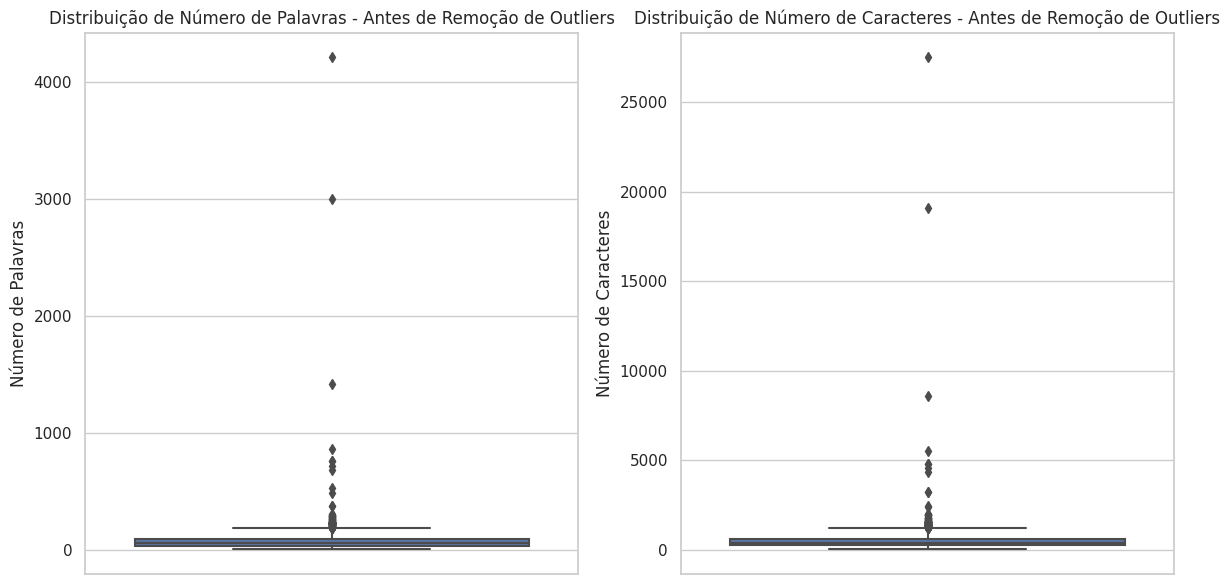

None

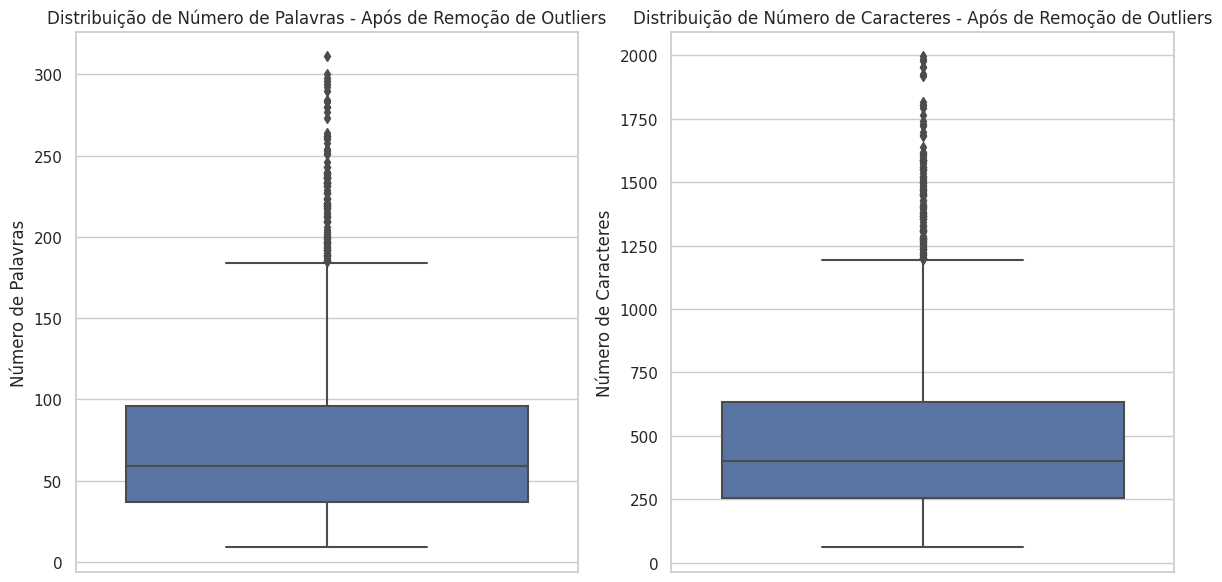

None

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=df_ementas["num_palavras"], ax=ax[0])
ax[0].set_title("Distribuição de Número de Palavras - Antes de Remoção de Outliers")
ax[0].set_ylabel("Número de Palavras")
sns.boxplot(y=df_ementas["num_caracteres"], ax=ax[1])
ax[1].set_title("Distribuição de Número de Caracteres - Antes de Remoção de Outliers")
ax[1].set_ylabel("Número de Caracteres")
plt.tight_layout()
display(plt.show())

# Remover linhas onde num_caracteres > 2000
df_ementas = df_ementas[df_ementas['num_caracteres'] <= 2000]
# Remover linhas onde num_caracteres < 50
df_ementas = df_ementas[df_ementas['num_caracteres'] >= 50]

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=df_ementas["num_palavras"], ax=ax[0])
ax[0].set_title(f"Distribuição de Número de Palavras - Após de Remoção de Outliers")
ax[0].set_ylabel("Número de Palavras")
sns.boxplot(y=df_ementas["num_caracteres"], ax=ax[1])
ax[1].set_title(f"Distribuição de Número de Caracteres - Após de Remoção de Outliers")
ax[1].set_ylabel("Número de Caracteres")
plt.tight_layout()
display(plt.show())


In [ ]:
def mostra_resumos(df_ementas, nome_dataframe):
    display(HTML(f'<h3>Resumos de {nome_dataframe}: (Qtd Total: {df_ementas.shape[0]})</h3>'))
    display(HTML("<br>- Distribuição do primeiro target ('julgado')"))
    df_ementas_grp1 = df_ementas.groupby(['julgado']).size().reset_index(name='qtd')
    df_ementas_grp1['%_total'] = (df_ementas_grp1['qtd'] / df_ementas.shape[0]) * 100
    display(df_ementas_grp1.style.pipe(df_style))
    display(HTML("<br>- Distribuição do segundo target ('imposto')"))
    df_ementas_grp2 = df_ementas.groupby(['imposto']).size().reset_index(name='qtd')
    df_ementas_grp2['%_total'] = (df_ementas_grp2['qtd'] / df_ementas.shape[0]) * 100
    display(df_ementas_grp2.style.pipe(df_style))

    display(HTML("<br>- Distribuição de 'julgado' dentro de 'imposto'"))
    dict_target2 = df_ementas_grp2.set_index('imposto')['qtd'].to_dict()
    df_ementas_grp3 = df_ementas.groupby(['imposto', 'julgado']).size().reset_index(name='qtd')
    df_ementas_grp3['%_total'] = (df_ementas_grp3['qtd'] / df_ementas.shape[0]) * 100
    df_ementas_grp3['qtd_imposto'] = df_ementas_grp3['imposto'].map(dict_target2)
    df_ementas_grp3['%_imposto'] = (df_ementas_grp3['qtd'] / df_ementas_grp3['qtd_imposto']) * 100
    display(df_ementas_grp3.style.pipe(df_style))

mostra_resumos(df_ementas, 'df_ementas')

,julgado,qtd,%_total
0,CANCELADO,171,"8,90"
1,MANTIDO,1751,"91,10"


,imposto,qtd,%_total
0,ICMS,1587,"82,57"
1,ITCMD,335,"17,43"


,imposto,julgado,qtd,%_total,qtd_imposto,%_imposto
0,ICMS,CANCELADO,80,"4,16",1587,"5,04"
1,ICMS,MANTIDO,1507,"78,41",1587,"94,96"
2,ITCMD,CANCELADO,91,"4,73",335,"27,16"
3,ITCMD,MANTIDO,244,"12,70",335,"72,84"


##⚖️ Necessidade de Balanceamento dos Dados
- O desbalanceamento de classes é uma situação comum em conjuntos de dados de aprendizado de máquina, sendo que não foi diferente neste TCC
- Conforme se verifica nos resumos acima, o número de observações é bastante diferente para as diferentes classes
- Essa é a razão da <b>necessidade inicial de download de grande quantidade de AIIMs no webscraper</b>. Ou seja, ao se fazer o balanceamento, ocorre o descarte de grande quantidade das classes majoritárias, para aumentar proporcionalmente a quantidade das classes minoritárias e, nesse sentido, a necessidade do máximo de download de elementos.
- Assim, quando da utilização de algoritmos de aprendizado, utilizaremos técnica de undersampling (subamostragem), onde necessário, para reduzir de forma aleatória a quantidade de amostras das classes majoritárias, reequilibrando proporcionamente as classes, bem como o desempenho para as minotárias.
- Abaixo, uma <b>proposta</b> inicial de <b>undersampling</b>, com a <b>criação de df_ementas_balanc</b>:
---
- <i><b>Observação:</b> É de se observar, curiosamente, que a quantidade de AIIMs de ITCMD cancelados é muito superior ao da quantidade de AIIMs de ICMS. Embora as causas dessa diferença específica não sejam objeto deste presente TCC, com base na experiência deste autor nos trabalhos dentro da Secretaria da Fazenda no Estado de São Paulo, é de se supor que a explicação seja advinda do fato de que os AIIMs de ITCMD são normalmente efetuados com muito menos provas do que os AIIMs de ICMS, posto que usualmente são lavrados apenas com uma simples cópia da declaração de imposto de renda da pessoa física autuada.</i>

In [ ]:
# Primeiro critério de undersampling
mask1 = (df_ementas['julgado'] == 'MANTIDO') & (df_ementas['imposto'] == 'ICMS')
amostra1 = df_ementas[mask1]
remover1 = amostra1.sample(frac=0.947)
# Segundo critério de undersampling
mask2 = (df_ementas['julgado'] == 'MANTIDO') & (df_ementas['imposto'] == 'ITCMD')
amostra2 = df_ementas[mask2]
remover2 = amostra2.sample(frac=0.673)
# Terceiro critério de undersampling
mask3 = (df_ementas['julgado'] == 'CANCELADO') & (df_ementas['imposto'] == 'ITCMD')
amostra3 = df_ementas[mask3]
remover3 = amostra3.sample(frac=0.12)

todos_a_remover = pd.concat([remover1, remover2, remover3])
df_ementas_balanc = df_ementas.drop(todos_a_remover.index)

mostra_resumos(df_ementas_balanc, 'df_ementas_balanc')

,julgado,qtd,%_total
0,CANCELADO,160,"50,00"
1,MANTIDO,160,"50,00"


,imposto,qtd,%_total
0,ICMS,160,"50,00"
1,ITCMD,160,"50,00"


,imposto,julgado,qtd,%_total,qtd_imposto,%_imposto
0,ICMS,CANCELADO,80,"25,00",160,"50,00"
1,ICMS,MANTIDO,80,"25,00",160,"50,00"
2,ITCMD,CANCELADO,80,"25,00",160,"50,00"
3,ITCMD,MANTIDO,80,"25,00",160,"50,00"


## 📤 Exportação para Excel

  - A qualquer momento, neste código, todos os dataframes podem ser exportados para Excel, possibilitando também outras visões e análises dos dados
  - O arquivo é salvo em /content/var/aiim.xlsx

In [ ]:
with pd.ExcelWriter(os.path.join(config['VAR_DIR'], 'tcc.xlsx')) as writer:
    df_aiim.to_excel(writer, sheet_name='aiim')
    df_aiim_mov.to_excel(writer, sheet_name='aiim_mov')
    df_aiim_decis.to_excel(writer, sheet_name='aiim_decis')
    df_dec.to_excel(writer, sheet_name='decis', index=False)
    df_dpi.to_excel(writer, sheet_name='decis_prim_inst')
    df_distr_julg.to_excel(writer, sheet_name='df_distr_julg', index=False)
    df_detec_ementas.to_excel(writer, sheet_name='df_detec_ementas')
    df_ementas.to_excel(writer, sheet_name='df_ementas')
    df_ementas_balanc.to_excel(writer, sheet_name='df_ementas_balanc')

display(HTML("<h3>Gerado com sucesso o arquivo excel 'tcc.xlsx'"
             + f" na pasta {config['VAR_DIR']},"
             + f" com abas de todos os dataframes</h3>"))

## 💾 Salvando os dataframes em SQLite
- A partir deste momento, o trabalho de aprendizado de máquina será efetuado em outros notebooks ipynb, a partir dos dados acima extraídos e selecionados.
- Assim, a necessidade de exportação dos dataframes para SQLite, para serem facilmente carregados logo ao início dos demais notebooks
O arquivo é salvo em /content/var/tcc.db

In [ ]:
# aiim, aiim_mov e aiim_decis já estão no arquivo SQLite tcc.db
df_dec.to_sql('df_dec', db.conn, if_exists='replace')
df_dpi.to_sql('df_dpi', db.conn, if_exists='replace')
df_distr_julg.to_sql('df_distr_julg', db.conn, if_exists='replace')
df_detec_ementas.to_sql('df_detec_ementas', db.conn, if_exists='replace')
df_ementas.to_sql('df_ementas', db.conn, if_exists='replace')
df_ementas_balanc.to_sql('df_ementas_balanc', db.conn, if_exists='replace')

display(HTML("<h3>Dataframes salvos com sucesso no arquivo SQLite 'tcc.db'"
             + f" na pasta {config['VAR_DIR']}</h3>"))

## 📦 Zip de Arquivos Auxiliares para Backup
- **Este trecho deve ser utilizado <u>apenas durante o desenvolvimento deste notebook (desenv = True) a apenas ao final</u>, em caso de necessidade compactação (zip) de Bibliotecas Auxiliares e AIIMs já baixados anteriormente, para posterior download ou salvamento, bem como na utilização no notebook de aprendizado de máquina**
  - core.zip = zip de /content/core
  - var_www.zip = zip de /content/var/www
  - var_txt.zip = zip de /content/var/txt
  - var_tcc.db.zip = zip de /content/var/tcc.db

In [ ]:
import os
import zipfile

desenv = False

def zipdir(path, ziph):
    # Percorre todo o diretório e subdiretórios e adiciona ao arquivo zip
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),
                       arcname=os.path.relpath(os.path.join(root, file),
                                               os.path.join(path, '..')))

def createzip(path, zip_file_path):
    if os.path.exists(zip_file_path):
        os.remove(zip_file_path)
    if os.path.isfile(path):
        with zipfile.ZipFile(zip_file_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(path, arcname=os.path.basename(path))
    else:
        folder_path = path
        with zipfile.ZipFile(zip_file_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
            zipdir(folder_path, zipf)
    print(f'Arquivo {zip_file_path} criado com sucesso a partir de {path}')

if desenv:
    createzip('/content/core', '/content/core.zip')
    createzip('/content/var/www', '/content/var_www.zip')
    createzip('/content/var/txt', '/content/var_txt.zip')
    createzip('/content/var/tcc.db', '/content/var_tcc.db.zip')
else:
    print("Fora do modo desenv não cria zip")


Fora do modo desenv não cria zip


## 📦 Salvamento dos Zips de Arquivos Auxiliares para Backup
- **Este trecho deve ser utilizado <u>apenas durante o desenvolvimento deste notebook (desenv = True) a apenas ao final</u>, para salvamento dos Zips gerados acima.**
- Caso necessário, pode ser efetuado download diretamente de core.zip e var.zip, nas opções disponibilidadas na janela de arquivos, em 📁, logo à esquerda

In [ ]:
from google.colab import drive
import shutil

if desenv:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    print(shutil.copy('/content/core.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/core.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_www.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_www.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_txt.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_txt.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_tcc.db.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_tcc.db.zip'),
          "copiado para o Google Drive!")
else:
    print("Fora do modo desenv não é possível salvar automaticamente.")
    print("Mas é possível fazer download dos arquivos .zip diretamente na janela Arquivos, em 📁, logo à esquerda")


Fora do modo desenv não é possível salvar automaticamente.
Mas é possível fazer download dos arquivos .zip diretamente na janela Arquivos, em 📁, logo à esquerda
